In [1]:
from MagicCube.cube import Cube
from pyTwistyScrambler import scrambler222
from enum import Enum

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize

import numpy as np
import pandas as pd

from gen_cases import convert_move

In [2]:
num_classes = 9
one_hot = np.identity(9)
possible_moves = ['F', "F'", 'F2', 'R', "R'", 'R2', 'U', "U'", 'U2']
move_mapping = dict(
    [(move, i) for i, move in enumerate(
        possible_moves
    )]
)
reverse_move_mapping = dict(
     [(v, k) for k, v in move_mapping.items()]
)
display(move_mapping) 
display(reverse_move_mapping)

{'F': 0, "F'": 1, 'F2': 2, 'R': 3, "R'": 4, 'R2': 5, 'U': 6, "U'": 7, 'U2': 8}

{0: 'F', 1: "F'", 2: 'F2', 3: 'R', 4: "R'", 5: 'R2', 6: 'U', 7: "U'", 8: 'U2'}

In [3]:
SAVE_STICKERS = "data/train_stickers.npy"
SAVE_PIECES = "data/train_pieces.npy"
SAVE_SOLUTIONS = "data/train_solutions.npy"

# Validate the test data

In [4]:
test_cube = Cube(2)

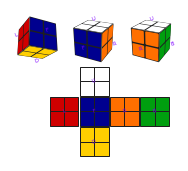

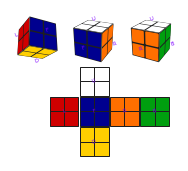

In [5]:
test_cube.render()

In [6]:
cube_sticker_shape = (6, 2, 2)

stickers = np.load(SAVE_STICKERS)
solutions = np.load(SAVE_SOLUTIONS)

idx = 8
sticker_state = stickers[idx].reshape(*cube_sticker_shape).astype(np.int64)

In [7]:
solution = list(reversed([reverse_move_mapping[enc] for enc in (solutions[0:idx+1])]))
' '.join(solution)

"U' F R2 F2 U' R U' R2 U'"

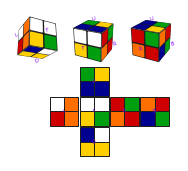

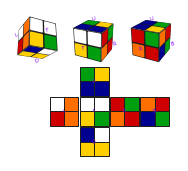

In [8]:
test_cube.stickers = sticker_state
test_cube.render()

In [9]:
for move in solution:
    print(f"moving: {move}")
    test_cube.move(*convert_move(move))

moving: U'
moving: F
moving: R2
moving: F2
moving: U'
moving: R
moving: U'
moving: R2
moving: U'


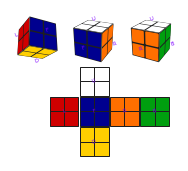

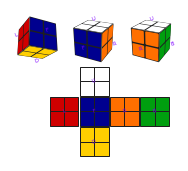

In [10]:
test_cube.render()

# Create training and validation sets

In [11]:
from torch.utils.data import Dataset, DataLoader

In [12]:
class CubeDataset(Dataset):
    def __init__(self, stickers, solutions):
        self.y = solutions.astype(np.int64)
        self.stickers = stickers.swapaxes(1, 3).astype(np.float64)
        self.n = stickers.shape[0]
    def __len__(self):
        return self.n
    def __getitem__(self, idx):
        return (self.stickers[idx], self.y[idx])


In [13]:
train_stickers = np.load(SAVE_STICKERS)
train_pieces = np.load(SAVE_PIECES)
train_solutions = np.load(SAVE_SOLUTIONS)

In [14]:
train_stickers.shape, train_pieces.shape, train_solutions.shape

((438086, 12, 2, 1), (438086, 8), (438086,))

In [15]:
size_dataset = len(train_solutions)

size_validation = int(size_dataset * .2)

In [16]:
train_stickers_X = train_stickers[:size_dataset-size_validation]
train_pieces_X = train_pieces[:size_dataset-size_validation]
train_y = train_solutions[:size_dataset-size_validation]

validation_stickers_X = train_stickers[-size_validation:]
validation_pieces_X = train_pieces[-size_validation:]
validation_y = train_solutions[-size_validation:]

In [17]:
display(train_stickers_X.shape, train_pieces_X.shape, train_y.shape)
display(validation_stickers_X.shape, validation_pieces_X.shape, validation_y.shape)

(350469, 12, 2, 1)

(350469, 8)

(350469,)

(87617, 12, 2, 1)

(87617, 8)

(87617,)

In [18]:
train_dataset = CubeDataset(train_stickers_X, train_y)
val_dataset = CubeDataset(validation_stickers_X, validation_y)

# Creating a Deep Learning architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

In [ ]:
batchsize = 128

train_dataloader = DataLoader(train_dataset, batchsize, shuffle=True)
val_dataloader = DataLoader(val_dataset, batchsize, shuffle=True)

In [ ]:
num_classes = 9

In [ ]:
class CubeNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=128,
            kernel_size=2, stride=1, padding=1
        )
        
        self.conv2 = nn.Conv2d(
            in_channels=128, out_channels=256,
            kernel_size=2, stride=1, padding=1
        )
        
        self.lin1 = nn.Linear(768, 100)
        self.dropout1 = nn.Dropout(.05)
        self.batchnorm1 = nn.BatchNorm1d(100)
        nn.init.kaiming_normal_(self.lin1.weight.data)
        
        self.output = nn.Linear(100, num_classes)
        nn.init.kaiming_normal_(self.output.weight.data)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(F.relu(self.conv1(x)), (2, 2)))
        x = F.relu(F.max_pool2d(F.relu(self.conv2(x)), (2, 2)))
        
        x = x.view(-1, 768)
        
        x = F.relu(self.lin1(x))
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        
        x = self.output(x)
        return x

# Perform a grid search for hyperparameters

In [ ]:
from livelossplot import PlotLosses

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')
print("Using device: " + str(device))

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10, should_plot=True, config={}):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.float().to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        if should_plot:
            liveloss.update(logs)
            liveloss.draw()
        if config:    
            print("Current config: ")
            pprint(config)
    return liveloss.metrics_extrema['val_log loss']['min'], \
        liveloss.metrics_extrema['val_accuracy']['max']

In [ ]:
dataloaders = {
    'train': val_dataloader,
    'validation': train_dataloader,
}

model = CubeNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [ ]:
train_model(model, criterion, optimizer, num_epochs=500)

# Experimental: Dense and Deep

In this attempt, we're seeing if a dense and deep architecture with aggressive dropouts generalizes well. One may argue that 2d convolutions don't quite work for a 3d puzzle.

In [20]:
MODEL_OUTPUT_FILE = "model/cube_net_experimental.pt"
PLOT_PATH = "img/loss_plot.png"

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

In [22]:
from livelossplot import PlotLosses

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')
print("Using device: " + str(device))

Using device: cuda


In [24]:
num_classes=9

# Attempting to add piece information to the dataset as well
class ExperimentalCubeDataset(Dataset):
    def __init__(self, stickers, pieces, solutions):
        self.y = solutions.astype(np.int64)
        self.stickers = stickers.swapaxes(1, 3).astype(np.int64)
        self.pieces = self._build_pieces(pieces)
        self.n = stickers.shape[0]
    def __len__(self):
        return self.n
    def __getitem__(self, idx):
        return (self.stickers[idx], self.pieces[idx], self.y[idx])
    
    def _build_pieces(self, pieces):
        #TODO: vectorize this
        num_pieces = 8
        output = np.zeros( pieces.shape, dtype=int)
        for i, example in enumerate(pieces):
            new_example = np.zeros( num_pieces, dtype=int )
            for cubit_position, encoded_color in enumerate(example):
                # encoded color ranges from [0, 7]
                new_example[int(encoded_color)] = cubit_position
            output[i] = new_example
        return output


In [25]:
experimental_train_dataset = ExperimentalCubeDataset(train_stickers_X, train_pieces_X, train_y)
experimental_val_dataset = ExperimentalCubeDataset(validation_stickers_X, validation_pieces_X, validation_y)

In [26]:
class ExperimentalCubeNet(nn.Module):
    def __init__(self, lin_layer_sizes, dropouts):
        super().__init__()
        
        # 24 stickers + 8 pieces * 3-dimensional embedding
        input_size = 48
        
        # DEFINITION: embedding
        self.embedding = nn.Embedding(8, 3)
        
        # DEFINITION: linear layers
        first_layer = nn.Linear(
            input_size, lin_layer_sizes[0]
        )
        self.linear_layers = nn.ModuleList(
            [first_layer] +
            [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
                for i in range(len(lin_layer_sizes) - 1)]
        )
        self.output_layer = nn.Linear(lin_layer_sizes[-1], num_classes)
        
        for l in self.linear_layers:
            nn.init.kaiming_normal_(l.weight.data)
        
        nn.init.kaiming_normal_(self.output_layer.weight.data)
        
        # DEFINITION: batchnorm layers
        self.first_bn_layer = nn.BatchNorm1d(input_size)
        self.bn_layers = nn.ModuleList(
             [nn.BatchNorm1d(size) for size in lin_layer_sizes]
        )
        
        # DEFINITION: dropout layers
        self.dropout_layers = nn.ModuleList(
             [nn.Dropout(d) for d in dropouts]
        )
        
    
    def forward(self, stickers, pieces):
        pieces = self.embedding(pieces)
        
        x = torch.cat(
            (pieces.reshape(-1, 24), stickers.reshape(-1, 24)),
            dim=1
        )
        
        x = self.first_bn_layer(x)
        
        for linear_layer, batchnorm, dropout in zip(
             self.linear_layers, self.bn_layers, self.dropout_layers
        ):
            x = F.relu(linear_layer(x))
            x = batchnorm(x)
            x = dropout(x)
        x = self.output_layer(x)
        return x

In [31]:
def train_model(model, criterion, optimizer, num_epochs=10, should_plot=True, config={}):
    save_response = input("Do you want to save this model? y/n ")
    should_save = save_response == "y" or raw_input == "yes"
    
    liveloss = PlotLosses(fig_path=PLOT_PATH)
    model = model.to(device)
    
    best_acc = float('-inf')
    epoch_last_improvement = -1
    
    for epoch in range(num_epochs):
        logs = {}
        epoch_loss = None
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for stickers, pieces, labels in dataloaders[phase]:
                stickers = stickers.float().to(device)
                pieces = pieces.to(device)
                labels = labels.to(device)

                outputs = model(stickers, pieces)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * labels.size(0)
                running_corrects += torch.sum(preds == labels.data)

            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'
                if epoch_acc.item() > best_acc:
                    best_acc = epoch_acc.item()
                    if should_save:
                        torch.save({
                            'epoch': epoch+1,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': loss
                        }, MODEL_OUTPUT_FILE)
                    

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        if should_plot:
            liveloss.update(logs)
            liveloss.draw()
        if config:    
            print("Current config: ")
            pprint(config)
    return liveloss.metrics_extrema['val_log loss']['min'], \
        liveloss.metrics_extrema['val_accuracy']['max']

In [34]:
batchsize = 1000

experimental_train_dataloader = DataLoader(experimental_train_dataset, batchsize, shuffle=True)
experimental_val_dataloader = DataLoader(experimental_val_dataset, batchsize, shuffle=True)

dataloaders = {
    'train': experimental_train_dataloader,
    'validation': experimental_val_dataloader,
}

model = ExperimentalCubeNet(
    lin_layer_sizes=[64, 128, 256, 512, 1024, 1024, 1024, 1024, 1024, 1024],
    dropouts=[.05, .05, .05, .1, .2, .2, .2, .2, .2, .2]
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

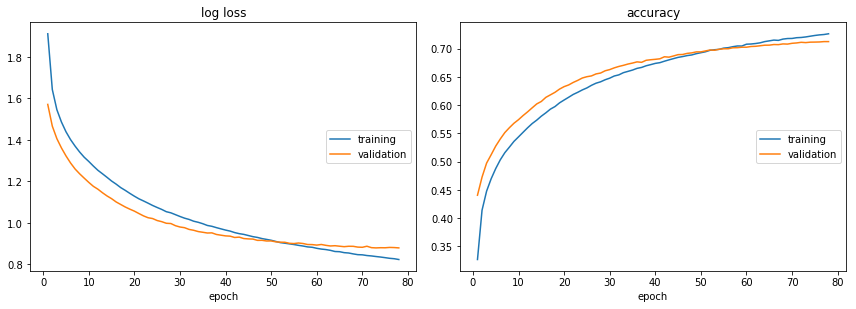

log loss:
training   (min:    0.823, max:    1.912, cur:    0.823)
validation (min:    0.879, max:    1.571, cur:    0.879)

accuracy:
training   (min:    0.326, max:    0.727, cur:    0.727)
validation (min:    0.440, max:    0.713, cur:    0.713)


KeyboardInterrupt: 

In [35]:
train_model(model, criterion, optimizer, num_epochs=1000)

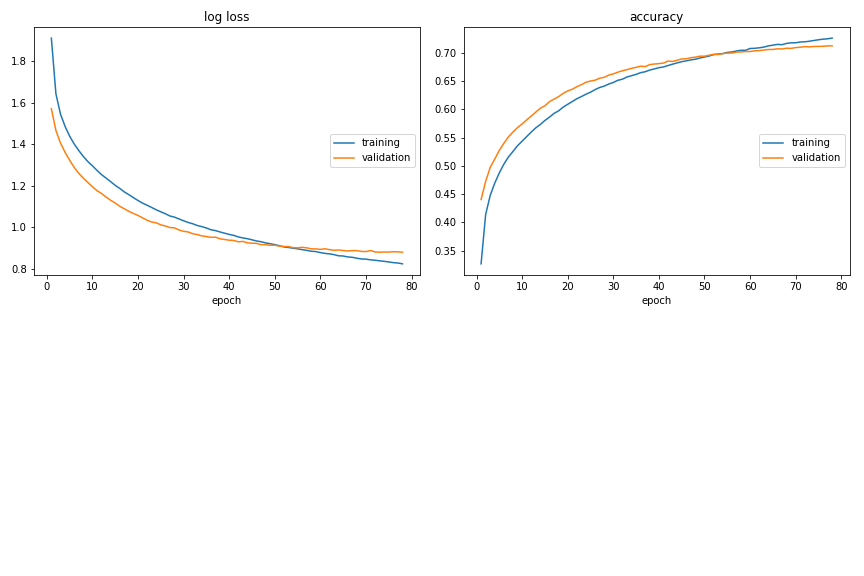

In [36]:
from IPython.display import Image
# Example loss plot from a previous run
Image(filename=PLOT_PATH)